In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import configparser
from pathlib import Path
import os
%matplotlib inline

from darts import TimeSeries
from darts.models import TFTModel
from darts.metrics import mae, mse, rmse, mape
from darts.utils.statistics import check_seasonality

Importing plotly failed. Interactive plots will not work.


In [2]:
configs = configparser.ConfigParser()
configs.read("configuracoes.conf",encoding='utf-8')

data_folder = Path(configs["DEFAULT"]["folder_path"])
path = data_folder / configs["DEFAULT"]["file"]
qtd_Meses = int(configs["DEFAULT"]["meses"])
objeto = configs["DEFAULT"]["objeto"]
regiao = configs["DEFAULT"]["regiao"]

df = pd.read_excel(path, parse_dates=['ano'])

#Dividir os dados em Treino e Validação
train_cesta = df.iloc[: -qtd_Meses:]
val_cesta = df.iloc[-qtd_Meses::]

#Criar TimeSeries usando os DataFrame
train_cesta = TimeSeries.from_dataframe(train_cesta, 'ano', 'razao')
val_cesta = TimeSeries.from_dataframe(val_cesta, 'ano', 'razao')
cesta = TimeSeries.from_dataframe(df.iloc[:-qtd_Meses:], 'ano', 'razao')

#ajustar dados para grafico
grafico_train = df.iloc[3 * -qtd_Meses::].copy()
grafico_train = grafico_train.iloc[:-qtd_Meses + 1:].copy()
grafico_train.reset_index(drop=True, inplace=True)
grafico_val = df.iloc[-qtd_Meses::].copy()

In [3]:
for lag in range(2, 64):
    season = check_seasonality(ts=train_cesta, m = lag, max_lag=64)
    if season[0]:
        print("sazonalidade com lag de", season[1])
        break

sazonalidade com lag de 36


[2022-03-03 10:12:06,949] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 145 samples.
[2022-03-03 10:12:06,949] INFO | darts.models.forecasting.torch_forecasting_model | Train dataset contains 145 samples.
[2022-03-03 10:12:06,966] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
[2022-03-03 10:12:06,966] INFO | darts.models.forecasting.torch_forecasting_model | Time series values are 64-bits; casting model to float64.
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs

   | Name                              | Type                             | Params
----------------------------------------------------------------------------------------
0  | static_covariates_vsn             | _VariableSelectionNetwork        | 0     
1  | encoder_vsn                       | _VariableSelectionNetwork        | 1.5 K 
2  | decoder_vsn          

Epoch 199: 100%|██████████| 5/5 [00:00<00:00, 16.77it/s, loss=0.105]
Predicting: 5it [00:00, ?it/s]

MAE : 0.08732
MSE :0.00773
RMSE :0.08793
MAPE :20.248%


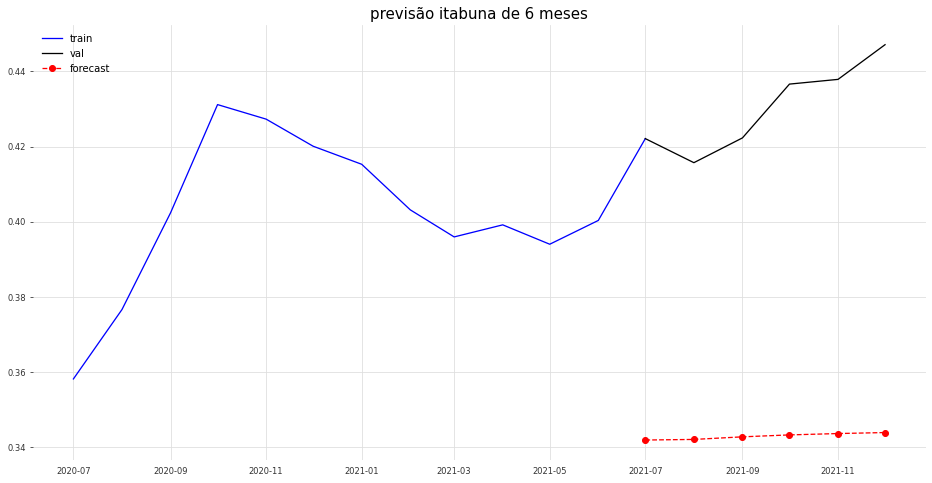

In [4]:
model_TFT = TFTModel(input_chunk_length = 48, output_chunk_length= qtd_Meses, n_epochs = 200, 
            dropout=0.2, hidden_size = 24, add_relative_index=True, lstm_layers=1) 

model_TFT.fit(series = [train_cesta])
forecast = model_TFT.predict(len(val_cesta), series = train_cesta)

print('\nMAE : {:.5f}\nMSE :{:.5f}\nRMSE :{:.5f}\nMAPE :{:.3f}%'.format(mae(val_cesta, forecast),
        mse(val_cesta, forecast), rmse(val_cesta, forecast), mape(val_cesta, forecast)))

forecast = forecast.pd_dataframe()
forecast.reset_index(inplace = True)

resultados = [round(previsao, 5) for previsao in forecast.razao.values]
objeto = objeto.replace(" ",'_')
output = {objeto.lower():str(resultados)}
filename = f"previsao_TFT_{objeto.lower()}_{regiao.lower()}_{qtd_Meses}_meses.json"
pasta_atual = os.getcwd()
full_url = Path(pasta_atual) / 'resultados'/ 'previsoes' / filename
os.makedirs(os.path.dirname(full_url), exist_ok=True)
with open(full_url,"w") as file:
    json.dump(output,file,ensure_ascii=False)

fig = plt.figure(figsize=(16, 8))
plt.title(f"previsão {regiao} de {qtd_Meses} meses", size=15)
plt.plot(grafico_train.ano, grafico_train.razao, label = 'train', color = 'blue')
plt.plot(grafico_val.ano, grafico_val.razao, label = 'val', color = 'black')
plt.plot(forecast.ano, forecast.razao, label = 'forecast', color = 'red', ls = '--', marker = 'o')
plt.legend()


## Avaliar os melhores hyperparametros

In [5]:
"""
input_chunk_length = [12, 37, 48]
epochs = [150, 200, 250, 300] 
hidden_sizes = [24, 32, 64]   
dropouts = [0.1, 0.2]

params = {'input_chunk_length': [], 'epochs': [] ,'hidden_size': [], 'dropout':[], 'RMSE': [], 'MAPE':[]}
best_params = {'input_chunk_length': None, 'epochs': None, 'hidden_size': None, 'dropout': None, 'RMSE': None, 'MAPE':None}

for input_size in input_chunk_length:
    for epoch in epochs:
        for hidden_size in hidden_sizes:
            for dropout in dropouts:
                model_TFT = TFTModel(input_chunk_length = input_size, output_chunk_length= qtd_Meses, n_epochs = epoch, 
                hidden_size = hidden_size, add_relative_index=True, lstm_layers=1, dropout = dropout)

                model_TFT.fit(series = [train_cesta], verbose = True)
                forecast = model_TFT.predict(len(val_cesta), series = train_cesta)

                rmse_model = rmse(val_cesta, forecast)
                mape_model = mape(val_cesta, forecast)

                if best_params['MAPE'] is None or mape_model < best_params['MAPE']:
                    best_params['input_chunk_length'] = input_size
                    best_params['epochs'] = epoch
                    best_params['hidden_size'] = hidden_size
                    best_params['dropout'] = dropout
                    best_params['RMSE'] = rmse_model
                    best_params['MAPE'] = mape_model

                params['input_chunk_length'].append(input_size)
                params['epochs'].append(epoch)
                params['hidden_size'].append(hidden_size)
                params['dropout'].append(dropout)
                params['RMSE'].append(rmse_model)
                params['MAPE'].append(mape_model)

df_params = pd.DataFrame(params)
"""

"\ninput_chunk_length = [12, 37, 48]\nepochs = [150, 200, 250, 300] \nhidden_sizes = [24, 32, 64]   \ndropouts = [0.1, 0.2]\n\nparams = {'input_chunk_length': [], 'epochs': [] ,'hidden_size': [], 'dropout':[], 'RMSE': [], 'MAPE':[]}\nbest_params = {'input_chunk_length': None, 'epochs': None, 'hidden_size': None, 'dropout': None, 'RMSE': None, 'MAPE':None}\n\nfor input_size in input_chunk_length:\n    for epoch in epochs:\n        for hidden_size in hidden_sizes:\n            for dropout in dropouts:\n                model_TFT = TFTModel(input_chunk_length = input_size, output_chunk_length= qtd_Meses, n_epochs = epoch, \n                hidden_size = hidden_size, add_relative_index=True, lstm_layers=1, dropout = dropout)\n\n                model_TFT.fit(series = [train_cesta], verbose = True)\n                forecast = model_TFT.predict(len(val_cesta), series = train_cesta)\n\n                rmse_model = rmse(val_cesta, forecast)\n                mape_model = mape(val_cesta, forecast)

In [6]:
#print(best_params)
#{'input_chunk_length': 48, 
#'epochs': 200,
#'hidden_size': 24,
#'dropout': 0.2, 
#'RMSE': 0.02487533089311727,
#'MAPE': 5.65911085051578}